In [575]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('./Suspects/Train_case_files80.csv')
df_test = pd.read_csv('./Suspects/New_suspects.csv')
df_validation = pd.read_csv('./Suspects/Validation_case_files20.csv')

In [576]:
df_validation = pd.read_csv('./Suspects/Validation_case_files20.csv')

suspect_truths = df_validation["suspect"]
print(df_validation["suspect"])

with open("Suspects/Validation_truths.txt", "w") as f:
    for truth in suspect_truths:
        f.write(f"{truth}\n")

0     innocent
1     innocent
2     innocent
3     innocent
4     innocent
        ...   
75    innocent
76    innocent
77    innocent
78      guilty
79      guilty
Name: suspect, Length: 80, dtype: object


In [577]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions(truth_file, predictions_file, positive_class='innocent', negative_class='guilty'):
    ground_truth = np.loadtxt(truth_file, dtype=str)
    predictions = np.loadtxt(predictions_file, dtype=str)

    # Compute confusion matrix values
    TP = sum((t == positive_class and p == positive_class) for t, p in zip(ground_truth, predictions))
    TN = sum((t == negative_class and p == negative_class) for t, p in zip(ground_truth, predictions))
    FP = sum((t == negative_class and p == positive_class) for t, p in zip(ground_truth, predictions))
    FN = sum((t == positive_class and p == negative_class) for t, p in zip(ground_truth, predictions))

    # Metrics for negative class
    Precision_1 = TN / (TN + FN)
    Recall_1 = TN / (TN + FP)
    F1_1 = 2 * (Precision_1 * Recall_1) / (Precision_1 + Recall_1)
    total_1 = sum(ground_truth == negative_class)

    # Metrics for positive class
    Precision_2 = TP / (TP + FP)
    Recall_2 = TP / (TP + FN)
    F1_2 = 2 * (Precision_2 * Recall_2) / (Precision_2 + Recall_2)
    total_2 = sum(ground_truth == positive_class)

    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    total_3 = total_1 + total_2

    # Create and print metrics table
    data = {
        'Class': [negative_class, positive_class],
        'Precision': [Precision_1, Precision_2],
        'Recall': [Recall_1, Recall_2],
        'F1-Score': [F1_1, F1_2],
        'total': [total_1, total_2]
    }
    df = pd.DataFrame(data)
    print(df.round(2))
    print('accuracy', round(Accuracy, 2), 'total samples:', total_3)

    # Create and display confusion matrix
    conf_matrix = np.array([[TN, FP],
                            [FN, TP]])
    print(conf_matrix)

    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
                xticklabels=[negative_class, positive_class],
                yticklabels=[negative_class, positive_class])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


                            Emotional Volatility  Deception Quotient  \
Emotional Volatility                    1.000000            0.325559   
Deception Quotient                      0.325559            1.000000   
Physical Strength                       0.997624            0.337283   
Authority Resistance                    0.984773            0.318599   
Athleticism                             0.192114            0.076543   
Sleight of Hand                         0.501955            0.314084   
Hypervigilance                          0.674402            0.372190   
Anticipation Ability                    0.822413            0.356721   
Reflex Score                            0.158683            0.112404   
Genetic Marker Score                   -0.330476            0.017252   
Weapon Proficiency                      0.665336            0.256469   
Motor Control                          -0.100465            0.356503   
Manipulation Tendency                   0.658988            0.25

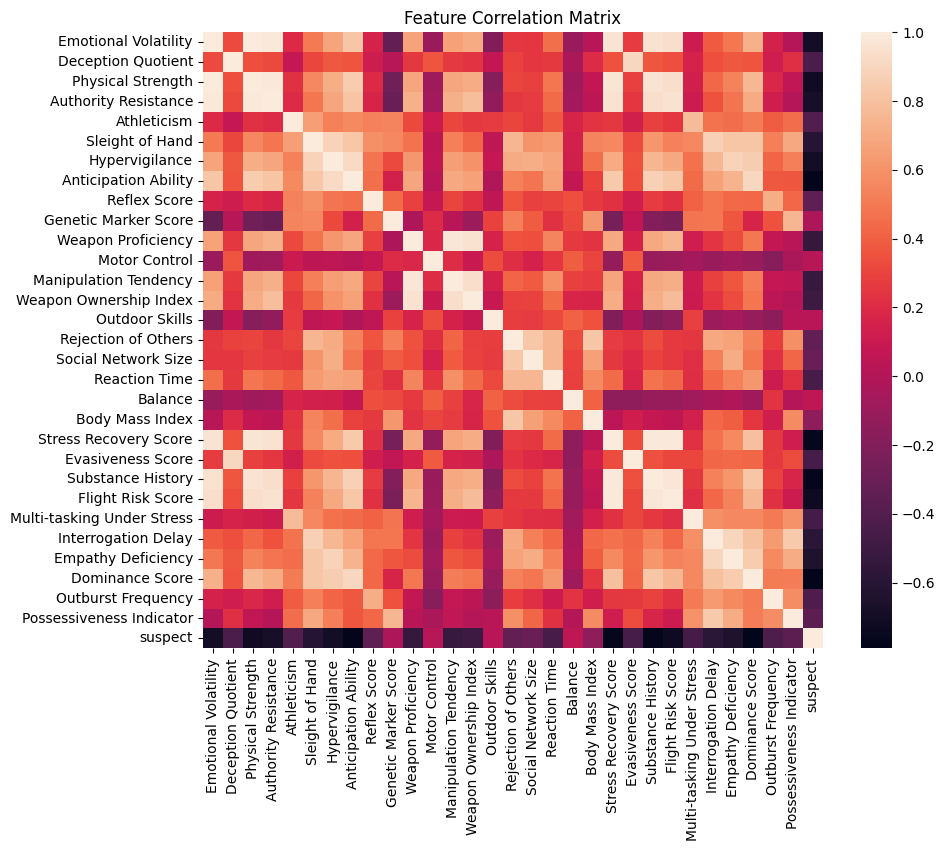

In [578]:
from sklearn.preprocessing import StandardScaler

# Load and prepare data
pd.set_option('display.max_columns', None)
df = df_train.copy()

# Encode target variable
df['suspect'] = df['suspect'].map({'guilty': 0, 'innocent': 1})

# Select numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)

# Compute and visualize correlation matrix
correlations = X_scaled_df.corr()

print(correlations)

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, cmap='rocket', annot=False, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Feature Correlation Matrix")
plt.show()


Variances (Percentage):
 [4.52666604e+01 1.71907509e+01 9.80640070e+00 6.29567798e+00
 5.18341503e+00 3.75411944e+00 2.47352551e+00 1.90257465e+00
 1.51460742e+00 1.17355856e+00 1.01033764e+00 8.85658279e-01
 7.32775271e-01 6.78112149e-01 4.24682241e-01 3.27603567e-01
 2.99747252e-01 2.38076898e-01 1.91118748e-01 1.51180249e-01
 1.10557361e-01 9.47113473e-02 7.91071366e-02 7.83205292e-02
 5.32768241e-02 3.10672159e-02 2.35175417e-02 2.04892258e-02
 5.66050622e-03 2.33291889e-03 3.76447846e-04]
Cumulative Variances (Percentage):
 [ 45.26666042  62.45741136  72.26381205  78.55949003  83.74290506
  87.4970245   89.97055001  91.87312467  93.38773209  94.56129065
  95.57162829  96.45728657  97.19006184  97.86817399  98.29285623
  98.6204598   98.92020705  99.15828395  99.3494027   99.50058295
  99.61114031  99.70585165  99.78495879  99.86327932  99.91655614
  99.94762336  99.9711409   99.99163013  99.99729063  99.99962355
 100.        ]


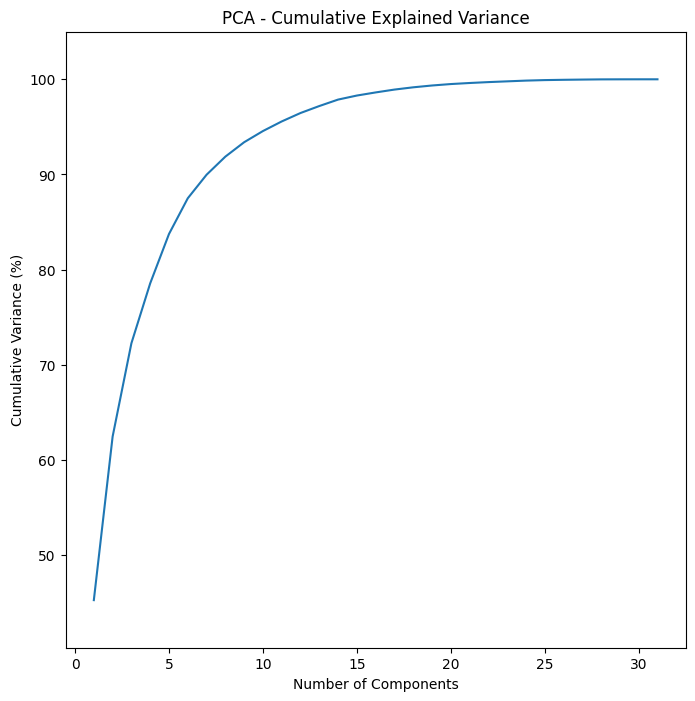

In [579]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load dataset
df = df_train.copy()

# Encode target if needed
df['suspect'] = df['suspect'].map({'guilty': 1, 'innocent': 0})

# Select only numeric features
numeric_df = df.select_dtypes(include='number')

# Scale features to 0–1 range
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Get explained variance
explained_var = pca.explained_variance_
explained_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_ratio.cumsum()

# Convert to DataFrame
pca_df = pd.DataFrame({
    'Component': range(1, len(explained_var)+1),
    'Explained Variance': explained_var,
    'Explained Variance Ratio (%)': explained_ratio * 100,
    'Cumulative Variance (%)': cumulative_variance * 100
})

# Print example values
print('Variances (Percentage):\r\n', pca_df['Explained Variance Ratio (%)'].to_numpy())
print('Cumulative Variances (Percentage):\r\n', pca_df['Cumulative Variance (%)'].to_numpy())

# Plot cumulative explained variance
plt.figure(figsize=(8, 8))
plt.plot(pca_df['Component'], pca_df['Cumulative Variance (%)'], marker='')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA - Cumulative Explained Variance')
plt.ylim(min(pca_df['Cumulative Variance (%)']) - 5, 100 + 5)
plt.show()


In [580]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Example dataframe
df = df_train.copy()

# Encode target if needed
df['suspect'] = df['suspect'].map({'guilty': 1, 'innocent': 0})

# Select only numeric features
numeric_df = df.select_dtypes(include='number')

# Add constant (intercept) term
X = add_constant(numeric_df)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data[""] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["Tolerance"] = 1 / vif_data["VIF"]

print(vif_data.to_string(index=False))

#Check for practical values
filtered_values = vif_data[vif_data['VIF'] < 5]
print(filtered_values.to_string(index=False))

                                   VIF  Tolerance
                     const 2300.059255   0.000435
      Emotional Volatility 4286.403615   0.000233
        Deception Quotient   11.223389   0.089100
         Physical Strength 4429.655089   0.000226
      Authority Resistance  403.466634   0.002479
               Athleticism    7.361950   0.135834
           Sleight of Hand   59.782499   0.016727
            Hypervigilance   75.262625   0.013287
      Anticipation Ability   56.800788   0.017605
              Reflex Score    4.006676   0.249583
      Genetic Marker Score   14.166886   0.070587
        Weapon Proficiency   83.007039   0.012047
             Motor Control    3.938346   0.253914
     Manipulation Tendency   76.206688   0.013122
    Weapon Ownership Index   49.567660   0.020174
            Outdoor Skills    3.691006   0.270929
       Rejection of Others   25.401724   0.039367
       Social Network Size   20.088272   0.049780
             Reaction Time   13.529649   0.073912


['innocent' 'innocent' 'innocent' 'innocent' 'innocent' 'innocent'
 'innocent' 'innocent' 'guilty' 'guilty' 'innocent' 'guilty' 'guilty'
 'innocent' 'innocent' 'innocent' 'guilty' 'innocent' 'guilty' 'innocent'
 'guilty' 'innocent' 'guilty' 'innocent' 'innocent' 'innocent' 'innocent'
 'innocent' 'innocent' 'innocent' 'innocent' 'innocent' 'innocent'
 'guilty' 'guilty' 'innocent' 'innocent' 'guilty' 'guilty' 'guilty'
 'guilty' 'guilty' 'guilty' 'guilty' 'innocent' 'guilty' 'innocent'
 'innocent' 'guilty' 'guilty' 'innocent' 'innocent' 'innocent' 'guilty'
 'innocent' 'guilty' 'innocent' 'innocent' 'guilty' 'guilty' 'guilty'
 'innocent' 'guilty' 'guilty' 'innocent' 'innocent' 'guilty' 'innocent'
 'innocent' 'guilty' 'innocent' 'innocent' 'guilty' 'innocent' 'innocent'
 'innocent' 'innocent' 'innocent' 'guilty' 'guilty']
Mean accuracy: 0.963, Std: 0.050
      Class  Precision  Recall  F1-Score  total
0    guilty       1.00    0.97      0.98     33
1  innocent       0.98    1.00      0.99  

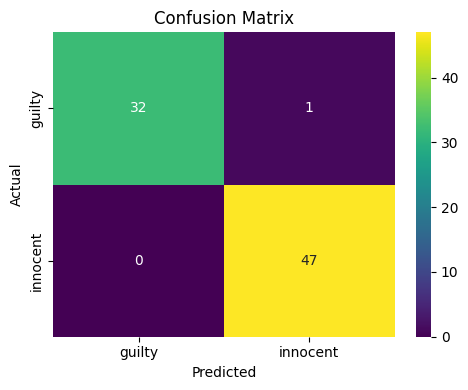

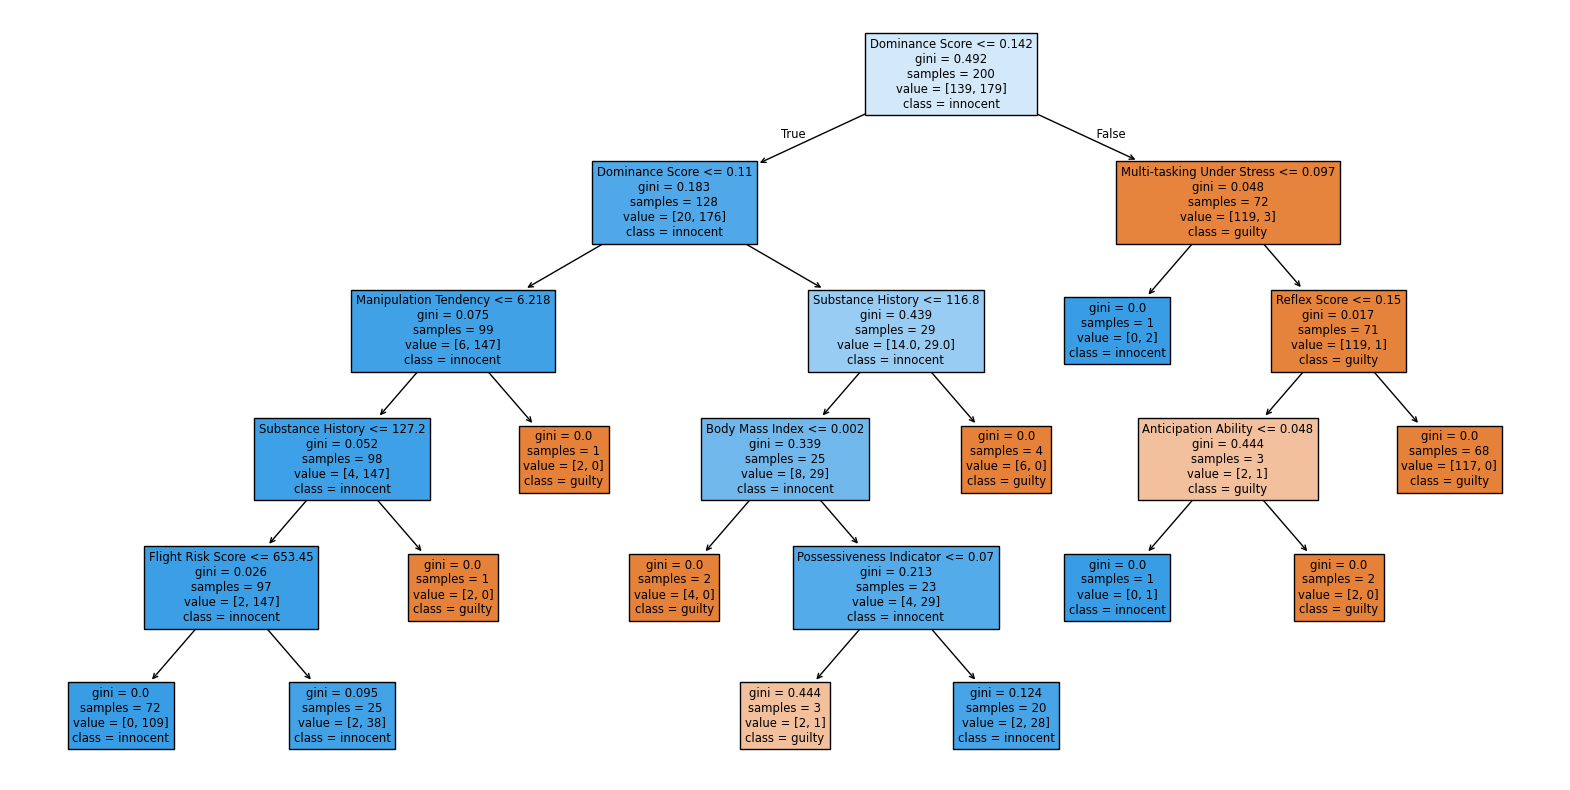

In [581]:
import sys

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Extract data from files
train_df = df_train.copy()
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

valid_df = df_validation.copy()
y_valid = valid_df.iloc[:, -1]
X_valid = valid_df[X_train.columns]

test_df = df_test.copy()
y_test = test_df.iloc[:, -1]
X_test = test_df[X_train.columns]

# Train model
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=5,
                             max_features='sqrt',
                             max_leaf_nodes=12,
                             random_state=42)
clf.fit(X_train, y_train)

# Predict
y_valid_pred = clf.predict(X_valid)



# Save predictions to Tree.txt
f1 = f1_score(y_valid, y_valid_pred, average='weighted')
print(y_valid_pred)
with open("Suspects/Tree_predictions_validate.txt", "w") as f:
    for value in y_valid_pred:
        f.write(f"{value}\n")

# Evaluate on validation set
scores = cross_val_score(clf, X_valid, y_valid, cv=5)
print(f"Mean accuracy: {scores.mean():.3f}, Std: {scores.std():.3f}")
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/Tree_predictions_validate.txt")

# Display data on plot_tree graph
plt.figure(figsize=(20, 10))
tree.plot_tree(clf.estimators_[0], filled=True, feature_names=X_train.columns, class_names=clf.classes_)
plt.show()


Best k = 2; f1_score = 0.975
Worst k = 1; f1_score = 0.925


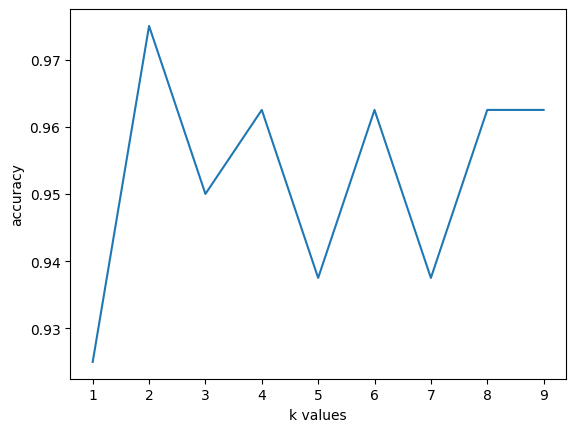

Using k value:  2
      Class  Precision  Recall  F1-Score  total
0    guilty       0.94    1.00      0.97     33
1  innocent       1.00    0.96      0.98     47
accuracy 0.97 total samples: 80
[[33  0]
 [ 2 45]]


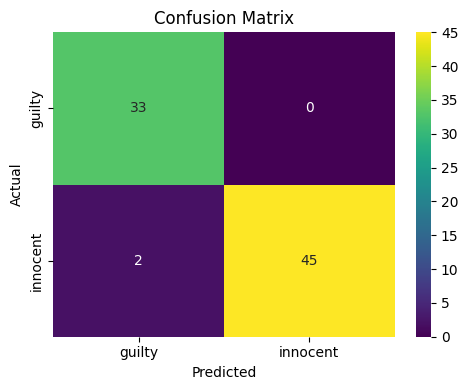

Using k value:  1
      Class  Precision  Recall  F1-Score  total
0    guilty       0.97    0.85      0.90     33
1  innocent       0.90    0.98      0.94     47
accuracy 0.93 total samples: 80
[[28  5]
 [ 1 46]]


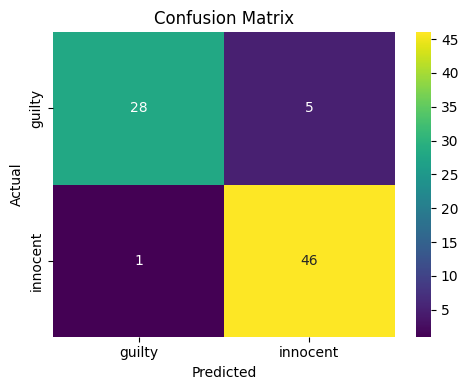

In [582]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


# Extract data from files
train_df = df_train.copy()
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

valid_df = df_validation.copy()
y_valid = valid_df.iloc[:, -1]
X_valid = valid_df[X_train.columns]


# Precision % according to the count of k-value
k_values = range(1, 10)
f1_scores = []
for k in k_values :
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_valid)
            acc = accuracy_score(y_valid, y_pred)
            f1_scores.append(acc)

max_f1 = max(f1_scores)
min_f1 = min(f1_scores)
best_k = k_values[f1_scores.index(max_f1)]
worst_k = k_values[f1_scores.index(min_f1)]
print (f"Best k = {best_k}; f1_score = {max_f1}")
print (f"Worst k = {worst_k}; f1_score = {min_f1}")
plt.plot(k_values, f1_scores)
plt.ylabel("accuracy")
plt.xlabel("k values")
plt.show()

# Predict using best k values
k = best_k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
prediction_best = knn.predict(X_valid)

# Predict using worst k values
k = worst_k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
prediction_worst = knn.predict(X_valid)

# Save predictions in a file
with open("Suspects/KNN_best_validate.txt", "w") as f:
        for value in prediction_best:
            f.write(f"{value}\n")

with open("Suspects/KNN_worst_validate.txt", "w") as f:
        for value in prediction_worst:
            f.write(f"{value}\n")

# Evaluate
print("Using k value: ", best_k)
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/KNN_best_validate.txt")
print("Using k value: ", worst_k)
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/KNN_worst_validate.txt")



      Class  Precision  Recall  F1-Score  total
0    guilty       1.00    0.97      0.98     33
1  innocent       0.98    1.00      0.99     47
accuracy 0.99 total samples: 80
[[32  1]
 [ 0 47]]


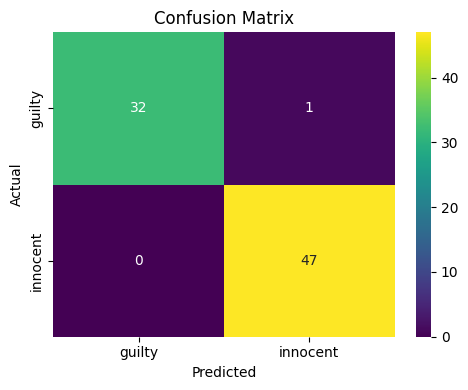

F1-Score on validation set: 0.9895


In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# Extract data from files
train_df = df_train.copy()
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

valid_df = df_validation.copy()
y_valid = valid_df.iloc[:, -1]
X_valid = valid_df[X_train.columns]

test_df = df_test.copy()
y_valid = test_df.iloc[:, -1]
X_valid = test_df[X_train.columns]

# Define classifiers
clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = LogisticRegression(max_iter=3000)

#Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', clf1),
    ('rf', clf2),
    ('lr', clf3)
], voting='soft')

# Train model
voting_clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = voting_clf.predict(X_valid)
f1 = f1_score(y_valid, y_pred_val, pos_label='innocent')
with open("Suspects/Voting_predictions_validate.txt", "w") as f:
    for label in y_pred_val:
        f.write(f"{label}\n")
evaluate_predictions("Suspects/Validation_truths.txt", "Suspects/Voting_predictions_validate.txt")
print(f"F1-Score on validation set: {f1:.4f}")

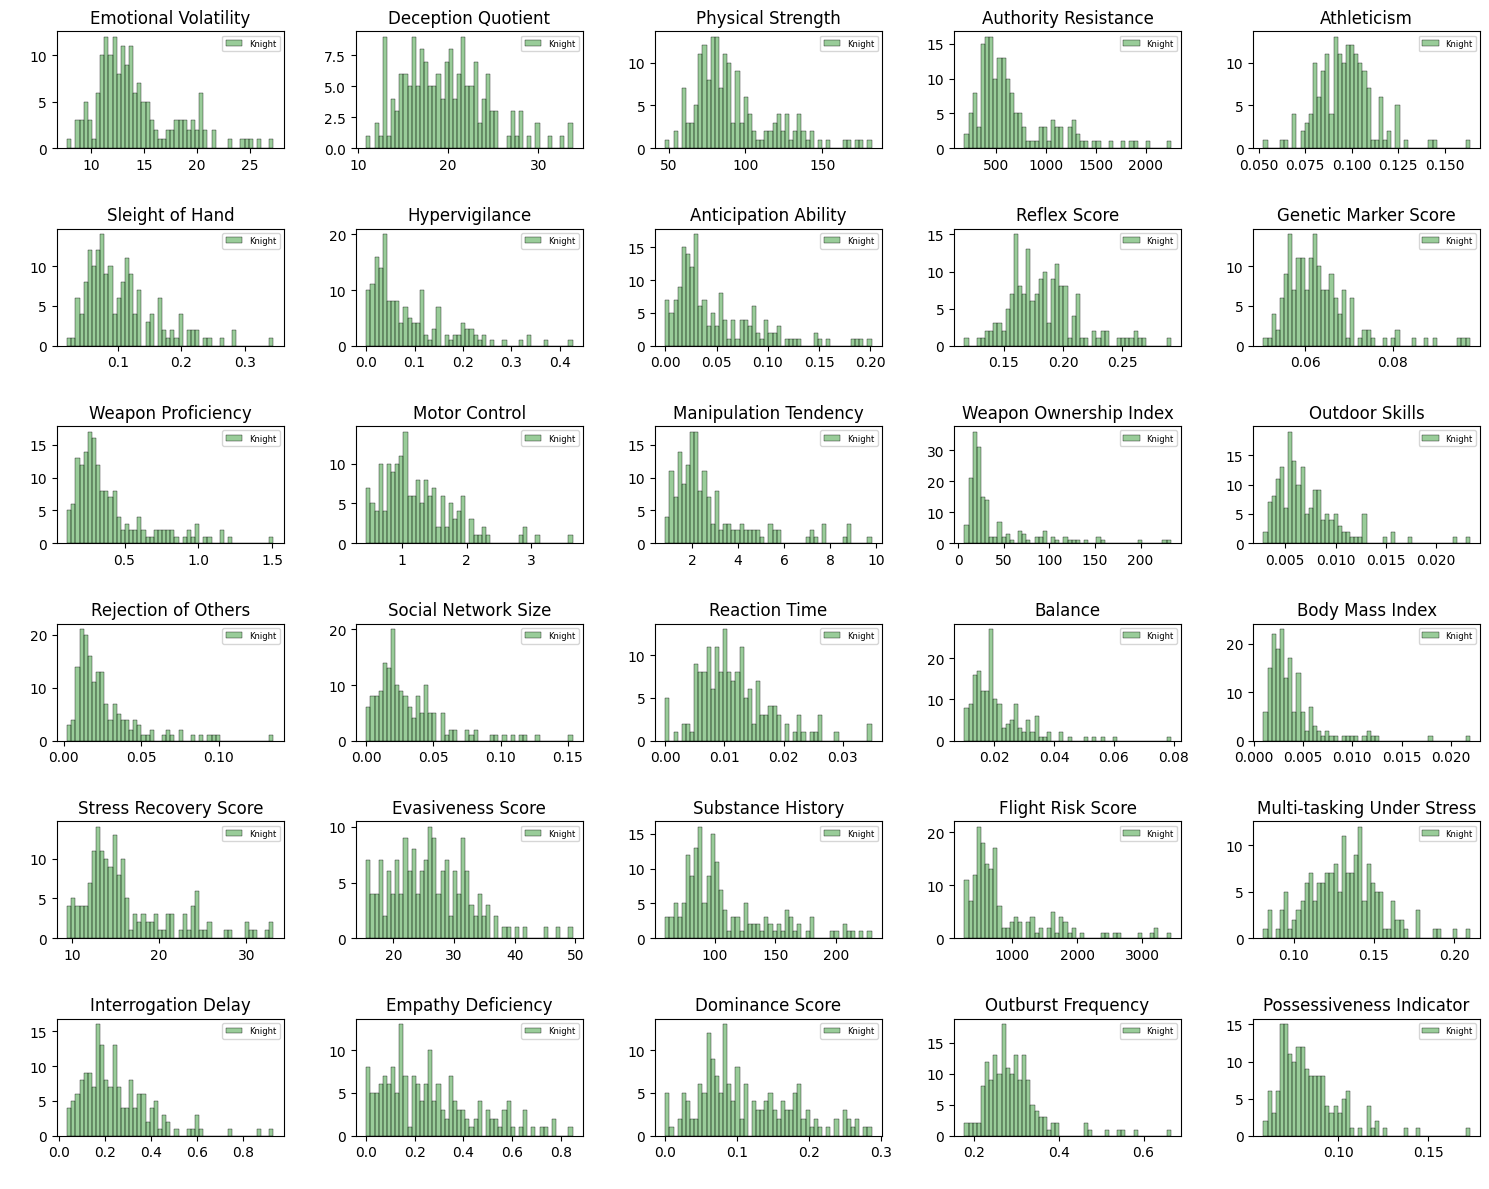

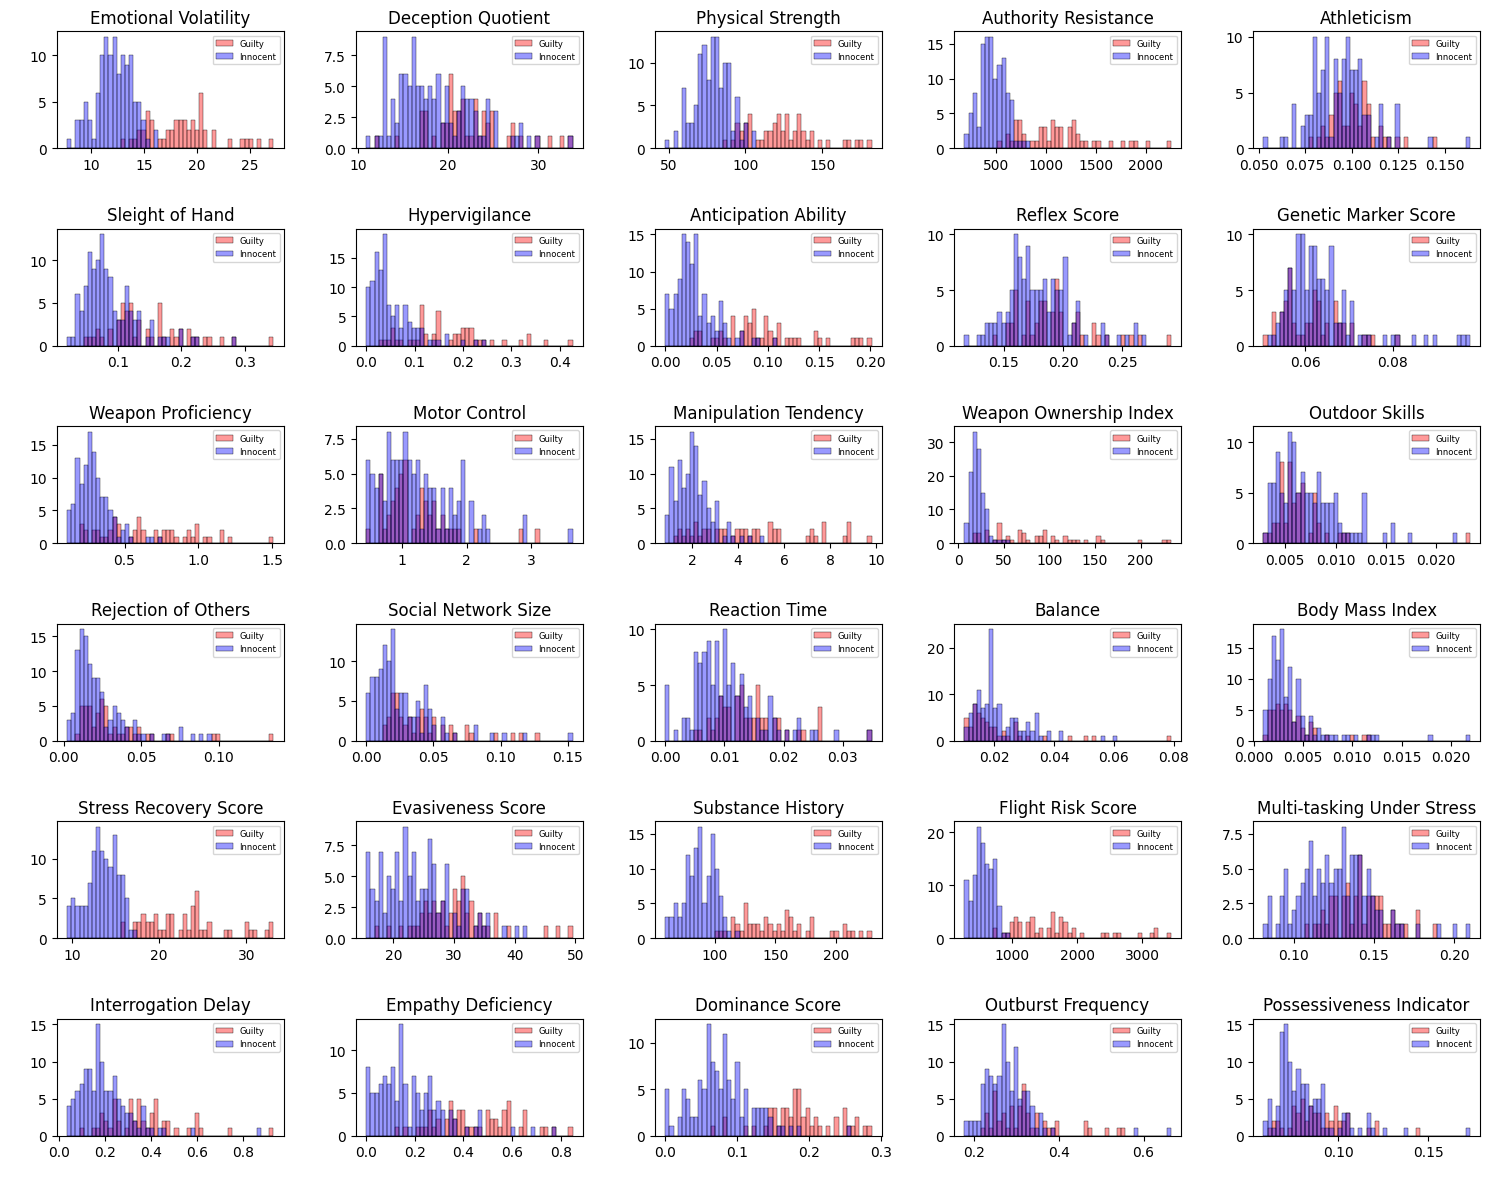

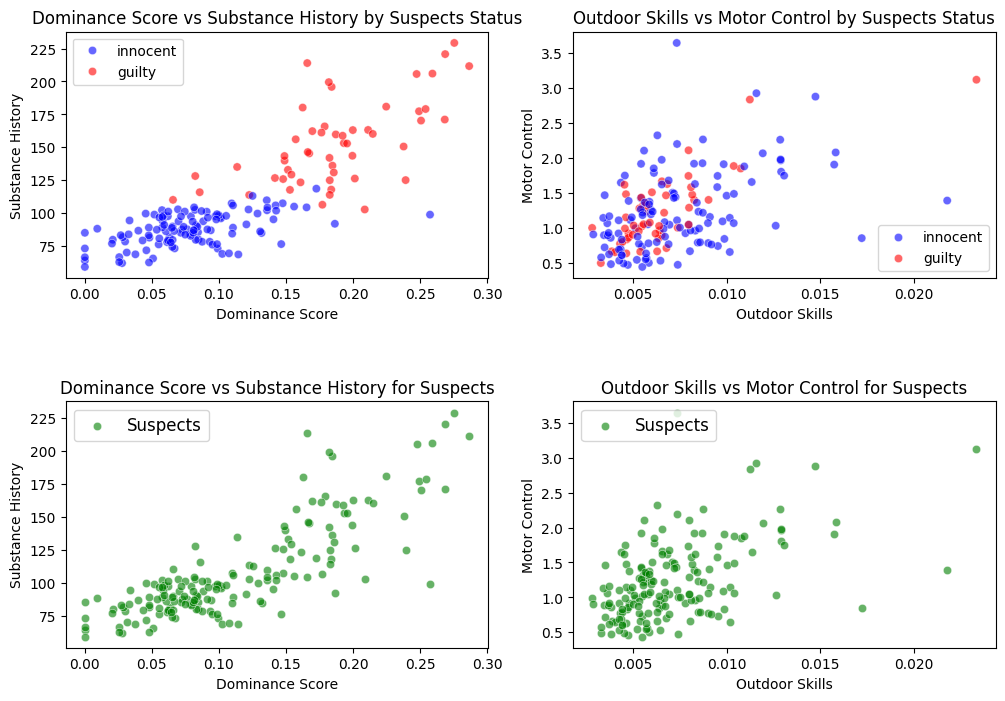

In [590]:

import matplotlib.pyplot as plt
import seaborn as sns

y_pred_val_test = voting_clf.predict(X_test)
df_test = pd.read_csv('./Suspects/New_suspects.csv')
df_test_predicted = df_test.copy()
df_test_predicted['suspect'] = y_pred_val_test

# Select only numeric columns
numeric_cols = df_test_predicted.select_dtypes(include='number').columns

# Set up the grid size
num_items = len(numeric_cols)
cols = 5
rows = (num_items + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 2 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_test,
                 x=col,
                 bins=50,
                 ax=axes[i],
                 kde=False,
                 color='green',
                 alpha=0.4)   
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')
    axes[i].legend(['Knight'], loc='upper right', fontsize=6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 2 * rows))
axes = axes.flatten()  # Flatten 2D array of axes to 1D for easy indexing

# Plot each numeric column
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_test_predicted,
                 x=col,
                 bins=50,
                 ax=axes[i],
                 hue='suspect',
                 palette=['blue', 'red'],
                 kde=False,
                 alpha=0.4)   
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')
    axes[i].legend(['Guilty', 'Innocent'], loc='upper right', fontsize=6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,2,1)
sns.scatterplot(data=df_test_predicted, x='Dominance Score', y='Substance History', hue='suspect', alpha=0.6, palette={'innocent': 'blue', 'guilty': 'red'})
plt.legend()
plt.title("Dominance Score vs Substance History by Suspects Status")

plt.subplot(2,2,2)
sns.scatterplot(data=df_test_predicted, x='Outdoor Skills', y='Motor Control', hue='suspect', alpha=0.6, palette={'innocent': 'blue', 'guilty': 'red'})
plt.legend()
plt.title("Outdoor Skills vs Motor Control by Suspects Status")


plt.subplot(2,2,3)
sns.scatterplot(data=df_test, x='Dominance Score', y='Substance History', alpha=0.6, color='green')
plt.legend(['Suspects'], loc='upper left', fontsize=12)
plt.title("Dominance Score vs Substance History for Suspects")

plt.subplot(2,2,4)
sns.scatterplot(data=df_test, x='Outdoor Skills', y='Motor Control', alpha=0.6, color='green')
plt.legend(['Suspects'], loc='upper left', fontsize=12)
plt.title("Outdoor Skills vs Motor Control for Suspects")
plt.show()
